In [1]:
import cv2 as cv2
import numpy as np

import matplotlib.pyplot as plt 

from skimage.morphology import remove_small_holes
from skimage.morphology import remove_small_objects

#import sys
#import math

In [37]:
img = cv2.imread('/content/drive/MyDrive/Intro to CV/HW 2/train_4.jpg')
img_orig = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

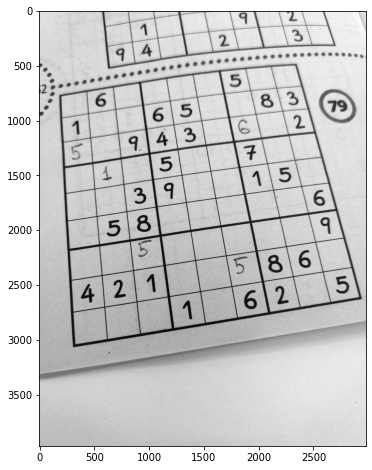

In [38]:
plt.figure(figsize=(12,8))
plt.imshow(gray, cmap="gray")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  """


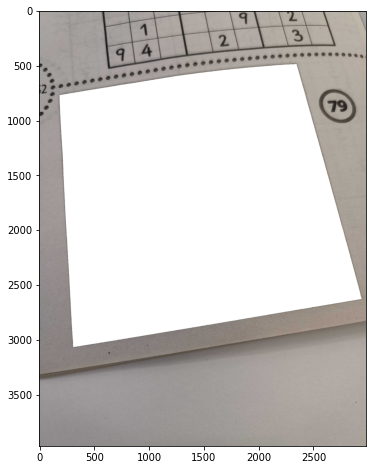

In [39]:
blur = cv2.medianBlur(gray, 3)

thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3)

thresh = remove_small_holes(thresh, area_threshold= 180, connectivity=2, in_place=False)
thresh = remove_small_objects(thresh, min_size = 300, connectivity=2, in_place=False)
thresh = thresh.astype(np.uint8)

kernel = np.ones((15,15))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

img_cnt = img_orig.copy()

if len(cnts) != 0:
    #find the biggest area
    c = max(cnts, key = cv2.contourArea)

    # filling in the biggest area
    cv2.fillPoly(img_cnt, pts =[c], color=(255,255,255))

    # trying to find the 2nd sudoku on the picture
    cntsSorted = sorted(cnts, key=cv2.contourArea)
    c_second = cnts[1]

    # checking the size of potential second sudoku on the picture
    if cv2.contourArea(c_second) >= 0.725 * cv2.contourArea(c): 
      cv2.fillPoly(img_cnt, pts =[c_second], color=(255,255,255))      

    #x,y,w,h = cv2.boundingRect(c)
    # draw the book contour (in blue)
    #cv2.rectangle(img_cnt,(x,y),(x+w,y+h),(0,0,255), 7)

#cv2.drawContours(img_cnt, cnts, -1, (0,255,0), 5)
plt.figure(figsize=(12,8))
plt.imshow(img_cnt)

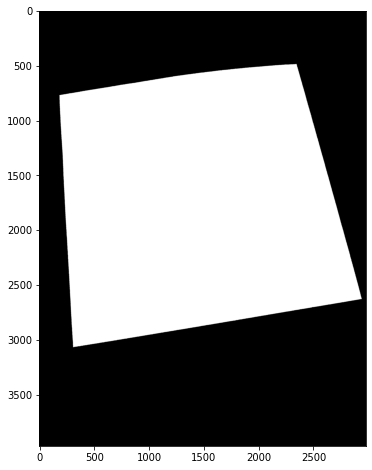

In [40]:
img_cnt[img_cnt != 255] = 0
plt.figure(figsize = (12,8))
plt.imshow(img_cnt)

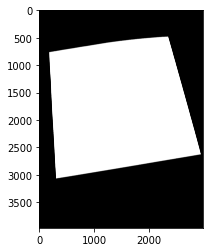

In [55]:
mask = img_cnt
mask = mask[:,:,0] + mask[:,:,1] + mask[:,:,2]
mask[mask != 0] = 1
plt.imshow(mask, cmap = "gray")